## Familiarization of TNG Data Acess
### Goals

* Graph 3D time-dependent distribution of things (e.g. stellar mass, Europeum, star formation rate)

In [8]:
import requests
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors
import matplotlib.ticker as ticker

In [9]:
base_url = 'http://www.tng-project.org/api/'
headers = {'api-key': '869b608c817d0a731e5439be3345bdf7'}

In [10]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [11]:
r = get(base_url)
name_list = [sim['name'] for sim in r['simulations']]
index = name_list.index('TNG100-3')
sim = get(r['simulations'][index]['url'])

In [12]:
#Getting particular subhalo
snaps_json = get(sim['snapshots'])
num_snaps = len(snaps_json)


The following code block and current markdown is for testing purposes it can be removed later

## Graphing of Data
### 1D Distributions

In [13]:
#Inits
vars_list, snap_num_list = [], [] #Should have tuples of sfr, stellar_mass, and mass of NSNS
subhalo_id = 13
param_target = 'GFM_MetalsTagged'
metal_num = 3
params = {'stars':param_target, 'gas':param_target}


for i in range(0, num_snaps):

    snap = get(snaps_json[i]['url'])
    snap_num_list.append(snap['number'])
    subhalos_json = get(snap['subhalos'], {'limit':'100'})
    sfr, stellar_mass, metal_total = None, None, 0
    if subhalos_json['count'] > subhalo_id:
        
        try:
            subhalo = get(subhalos_json['results'][subhalo_id]['url'])
            sfr, stellar_mass = subhalo['sfr'], subhalo['mass_stars']

            try:
                subhalo_cutout = get(subhalo['cutouts']['subhalo'], params)

                #Opens hd5f file and takes out amount of metal
                with h5py.File(subhalo_cutout, 'r') as f:
                    metals_star = f['PartType4'][param_target]
                    metals_gas = f['PartType0'][param_target]
                    for metal_array in metals_star: metal_total += metal_array[metal_num]
                    for metal_array in metals_gas: metal_total += metal_array[metal_num]

            except: #Catches HTTP error but for some reason I could not install urllib2 on my server
                pass

        except IndexError:
            pass
        
    
    vars_list.append((sfr, stellar_mass, metal_total))

In [ ]:
subhalos_json = get(snap['subhalos'], {'limit':'10000'})
for s_id in range(0, 100000):
    subhalo = get(subhalos_json['results'][subhalo_id]['url'])
    if 'stellar_mocks' in subhalo['supplementary_data']: print('img {}'.format(s_id))
    continue

In [23]:
sfr_list, stellar_mass_list, metal_list = zip(*vars_list)

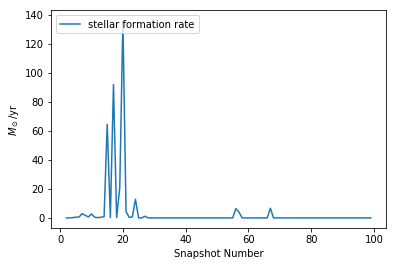

In [24]:
plt.plot(snap_num_list, sfr_list, label = 'stellar formation rate')
plt.xlabel('Snapshot Number')
plt.ylabel('$M_\odot$/yr')
plt.legend(loc='upper left')
plt.show()

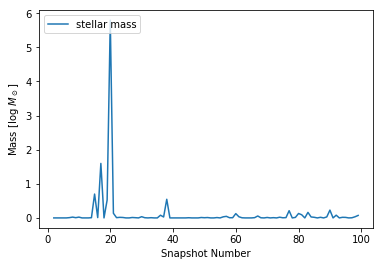

In [25]:
plt.plot(snap_num_list, stellar_mass_list, label = 'stellar mass')
plt.xlabel('Snapshot Number')
plt.ylabel('Mass [log $M_\odot$]')
plt.legend(loc='upper left')
plt.show()

(0, 0, 1.4000000186920047e-09, 2.600000034713723e-09, 4.939651181146143e-09, 0, 9.493850004760329e-09, 0, 1.9747722089513697e-08, 0, 0, 4.251151673739795e-09, 0, 4.351760278520356e-09, 0, 0, 0, 2.8661628706048298e-06, 0, 0, 0, 1.4648348825585522e-07, 0, 0, 0, 1.5016853038840594e-10, 0, 0, 0, 0, 0, 0, 0, 1.0867289013116732e-10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.056131362919821e-10, 0, 0, 0, 0, 0, 0, 0, 0, 1.5257167751414613e-09, 0, 0, 0, 0, 0, 0, 0, 1.736409492636426e-06, 0, 0, 0, 0, 2.139970284309456e-10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.747251272640973e-08, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.723472903783721e-08)


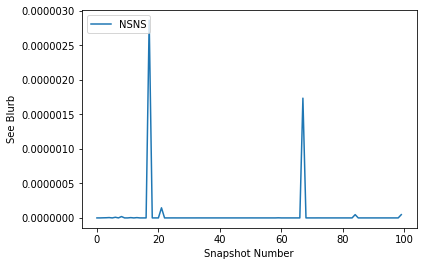

In [26]:
print(metal_list)
plt.plot(snap_num_list, metal_list, label = 'NSNS')
plt.xlabel('Snapshot Number')
plt.ylabel('See Blurb')
plt.legend(loc='upper left')
plt.show()

### 3D Distributions

In [27]:
#Inits
pos_list, snap_num_list = [], []
subhalo_id = 13
param_target_1 = 'GFM_MetalsTagged'
param_target_2 = 'Coordinates' 
total_param = param_target_1 + ',' + param_target_2
metal_num = 3 #For NSNS
params = {'stars':total_param, 'gas':total_param}

snap_num = 91
snap = get(snaps_json[snap_num]['url'])
snap_num_list.append(snap['number'])
subhalos_json = get(snap['subhalos'])

NSNS_gas_pos_amt_list = []
NSNS_star_pos_amt_list = []

subhalo = get(subhalos_json['results'][subhalo_id]['url'])
subhalo_cutout = get(subhalo['cutouts']['subhalo'], params)

#Opens hd5f file and takes out amount of metal
with h5py.File(subhalo_cutout, 'r') as f:
    metals_star = f['PartType4'][param_target_1][:]
    part_pos_star = f['PartType4'][param_target_2][:]
    metals_gas = f['PartType0'][param_target_1][:]
    part_pos_gas = f['PartType0'][param_target_2][:]

    num_star_particles = len(part_pos_star)
    for i in range(0, num_star_particles):
        NSNS_star_pos_amt_list.append((part_pos_star[i], metals_star[i][metal_num]))
    
    num_gas_particles = len(part_pos_gas)
    for i in range(0, num_gas_particles):
        NSNS_gas_pos_amt_list.append((part_pos_gas[i], metals_gas[i][metal_num]))




In [28]:
#Converting into more useable data type, try catch incase no gas/star particles
try:
    star_x_list, star_y_list, star_z_list = zip(*(NSNS_star_pos_amt[0] for NSNS_star_pos_amt in NSNS_star_pos_amt_list))
    star_NSNS_list = [NSNS_star_pos_amt[1] for NSNS_star_pos_amt in NSNS_star_pos_amt_list]
except ValueError:
    pass

try:
    gas_x_list, gas_y_list, gas_z_list = zip(*(NSNS_gas_pos_amt[0] for NSNS_gas_pos_amt in NSNS_gas_pos_amt_list))
    gas_NSNS_list = [NSNS_gas_pos_amt[1] for NSNS_gas_pos_amt in NSNS_gas_pos_amt_list]
except ValueError:
    pass


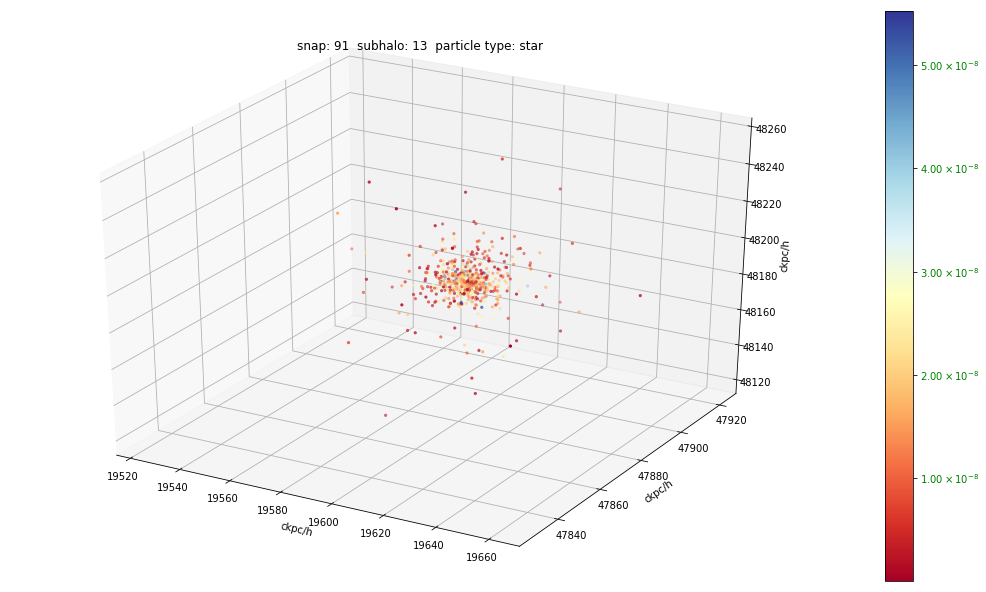

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
min_NSNS, max_NSNS = min(star_NSNS_list), max(star_NSNS_list)

cm = plt.cm.get_cmap('RdYlBu')

star_plot = ax.scatter(star_x_list, star_y_list, star_z_list, s=5, c=star_NSNS_list, vmin=min_NSNS, vmax=max_NSNS, cmap=cm)
ax.set_xlabel('ckpc/h')
ax.set_ylabel('ckpc/h')
ax.set_zlabel('ckpc/h')
ax.set_title('snap: {}  subhalo: {}  particle type: {}'.format(snap_num, subhalo_id, 'star'))

#When you attach as email, the background is white so I had to change colobar tick colors
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
color_bar = plt.colorbar(star_plot, format=ticker.FuncFormatter(fmt))                   
cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')
plt.setp(cbytick_obj, color='g')
fig.set_size_inches(18.5, 10.5)

In [30]:

if 'stellar_mocks' in subhalo['supplementary_data']: 
    # download PNG image, the version which includes all stars in the FoF halo (try replacing 'fof' with 'gz')
    png_url = subhalo['supplementary_data']['stellar_mocks']['image_fof']
    response = get(png_url)
    
    # make plot a bit nicer
    plt.subplot(1,len(ids),sub_count)
    plt.text(0,-20,"ID="+str(id),color='blue')
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])
    sub_count += 1
    
    # plot the PNG binary data directly, without actually saving a .png file
    file_object = StringIO(response.content)
    plt.imshow(mpimg.imread(file_object))

There are a lot of variables and sometimes it is hard to remember what each one of them mean, this link http://www.tng-project.org/data/docs/specifications/#sec1a gives a description of all of these variables and a basic structure of the API.